# Project 2: Graph Mining
*Due Wednesday November 14th, 2018 at 11:59 pm*

*Notebook Author: Koki Sasagawa*

Mining a large social network to uncover how well homophily can predict identity as well as the network structure. 

**Task2:** Attribute Prediction - most of the nodes in the social network are provided with one or more attributes that can be drawn from different types. (e.g., age, occupation, musical preference, etc. ) Predict the probabilities of attributes for a set of completely unlabeled nodes

## Data

1. `labeled-vertices.train.tsv` & `labeled-vertices.dev.tsv` & `unlabeled-verticies.test.tsv` 
   - users with attributes formatted as the following: 

   > - **vertex1** T1:3 T7:1 T4:2
   > - **vertex2** T2:4
   > - **vertex3** T4:3 T3:1
   
   - Each value is specified as `AttributeType:Value`
   - Not every user will have their attributes listed 
   - Majority users should have at least 2 attribute set
2. `unlabeled-verticies.test.txt` - simply have list of vertices that should predict attributes and their values 

## Submission 

**Attribute prediction** should be a csv file with two columns: id and attr. 
The attr column should contain a space-deliminted list of the attributes you think the user with that id has. The file should have the following structure:

> id, attr
> 
> 123, T0:0 T1:1 


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import networkx as nx
import time
# import os
# from pprint import pprint

## 1. Create Graph

In [2]:
print("Creating network graph...")
start_time = time.time() 

with open("../data/network.tsv", 'rb') as f:
    grph = nx.read_edgelist(path=f, delimiter='\t', encoding='utf8')

end_time = time.time()
print("Network graph created. Process took {:.04f} seconds".format(end_time - start_time))

# Check that graph is of correct size
print("Number of edges: {}".format(grph.number_of_edges())) # There should be 30915267
print("Number of nodes: {}".format(grph.number_of_nodes())) # There should be 6626753

Creating network graph...
Network graph created. Process took 346.0024 seconds
Number of edges: 30915267
Number of nodes: 6626753


## 2. Load all files for attribute prediction 

In [3]:
print("Reading in dev set...")
start_time = time.time()

dev_set_chunks = pd.read_csv("../data2/labeled-vertices.dev.tsv",
                             delimiter='\t',
                             usecols=[0,1],
                             names=['id', 'attr'],
                             header=None,
                             chunksize=100000)

dev_set = pd.concat(dev_set_chunks)

# Free memory 
dev_set_chunks = None

end_time = time.time()
print("Dev set loaded. Process took {:.04f} seconds".format(end_time - start_time))

# Check 
dev_set.head()

Reading in dev set...
Dev set loaded. Process took 0.3937 seconds


,id,attr
0,2666403,T0:2 T1:99
1,2627940,T0:0 T1:26
2,4843136,T0:0 T1:26
3,5396835,T0:0 T1:1813
4,5438188,T0:1 T1:1733


In [4]:
print("Reading in training set...")
start_time = time.time()

train_set_chunks = pd.read_csv("../data2/labeled-vertices.train.tsv",
                               delimiter='\t',
                               usecols=[0,1],
                               names=['id', 'attr'],
                               header=None,
                               chunksize=100000)

train_set = pd.concat(train_set_chunks)

# Free memory 
train_set_chunks = None

end_time = time.time()
print("Train set loaded. Process took {:.04f} seconds".format(end_time - start_time))

# Check 
print(train_set.shape[0])
train_set.head()

Reading in training set...
Train set loaded. Process took 2.1128 seconds
5301403


,id,attr
0,5509623,T0:0 T1:0
1,6334893,T0:0 T1:1
2,1218900,T0:1 T1:2
3,3871398,T0:1 T1:2
4,3942361,T0:0 T1:3


In [5]:
print('Reading in test set...')
start_time = time.time()

test_set = []

with open('../data2/unlabeled-vertices.test.txt') as f:
    for line in f:
        test_set.append(line.rstrip())

end_time = time.time()
print("Test set loaded. Process took {:.04f} seconds".format(end_time - start_time))

# Check 
test_set[:5]

Reading in test set...
Test set loaded. Process took 0.2168 seconds


['4546232', '3711008', '6394112', '5883774', '2843733']

## 3. Define the functions for attribute prediction

The following function will compute some similarity metric on the neighbors of a node, and the node will inherit the attributes of the highest scoring node.

In [6]:
def highest_jaccard_similarity(test_set, grph):
    '''Calculate then jaccard similarity of neighbors and return the most similar node
    
    If jaccard similarity of two nodes is zero, return 0 
    
    :params test_set: target nodes we want to find the most similar neighbor for
    :type test_set: list of str
    :params grph: network graph containing target nodes
    :type grph: networkx.classes.graph.Graph
    :returns: node and the most similar neighboring node
    :rtype: dict of {str : str}
    '''
    
    # Store results
    sim_results = {}
    
    for i in test_set:
        nearest_neighbors = list(grph.neighbors(i))
        # Make sure that node has neighbors
        if nearest_neighbors:
            # If a node only has only 1 neighbor, inherit that neighbors attributes 
            if len(nearest_neighbors) == 1: 
                sim_results[i] = nearest_neighbors[0]
            else:
                # Generate node-neighbor pairings 
                node_pairs = [(i, j) for j in nearest_neighbors]
                preds = nx.jaccard_coefficient(grph, ebunch=node_pairs)

                # Sort by similarity score
                preds = list(preds)
                preds.sort(key=lambda x: x[2], reverse=True)

                # Take the node with highest sim score
                # If similarity is 0, return 0
                if preds[0][2] == 0:
                    sim_results[i] = 0
                else:
                    sim_results[i] = preds[0][1]
        else: 
            sim_results[i] = 0

    return sim_results

In [7]:
def highest_adamic_adar_similarity(test_set, grph):
    '''Calculate then adamic/adar similarity of neighbors and return the most similar node
    
    If adamic/adar similarity of two nodes is zero, return 0
    
    :params test_set: target nodes we want to find the most similar neighbor for
    :type test_set: list of str
    :params grph: network containing target nodes
    :type grph: networkx.classes.graph.Graph
    :returns: node and the most similar neighboring node
    :rtype: dict of {str : str}
    '''
    
    # Store results
    sim_results = {}
    
    for i in test_set:
        nearest_neighbors = list(grph.neighbors(i))
        # Make sure that node has neighbors
        if nearest_neighbors:
            # If a node only has only 1 neighbor, inherit that neighbors attributes 
            if len(nearest_neighbors) == 1: 
                sim_results[i] = nearest_neighbors[0]
            else:
                # Generate node-neighbor pairings 
                node_pairs = [(i, j) for j in nearest_neighbors]
                preds = nx.adamic_adar_index(grph, ebunch=node_pairs)

                # Sort by similarity score
                preds = list(preds)
                preds.sort(key=lambda x: x[2], reverse=True)

                # Take the node with highest sim score
                # If similarity is 0, return 0
                if preds[0][2] == 0:
                    sim_results[i] = 0
                else:
                    sim_results[i] = preds[0][1]
        else:
            sim_results[i] = 0

    return sim_results

In [8]:
def highest_preferential_attachment_score(test_set, grph):
    '''Calculate then preferential attachment scores of neighbors and return the highest scoring node
    
    :params test_set: target nodes we want to find the most similar neighbor for
    :type test_set: list of str
    :params grph: network containing target nodes
    :type grph: networkx.classes.graph.Graph
    :returns: node and the most similar neighboring node
    :rtype: dict of {str : str}
    '''
    
    # Store results
    sim_results = {}
    
    for i in test_set:
        nearest_neighbors = list(grph.neighbors(i))
        # Make sure that node has neighbors
        if nearest_neighbors:
            # If a node only has only 1 neighbor, inherit that neighbors attributes 
            if len(nearest_neighbors) == 1: 
                sim_results[i] = nearest_neighbors[0]
            else:
                # Generate node-neighbor pairings 
                node_pairs = [(i, j) for j in nearest_neighbors]
                preds = nx.preferential_attachment(grph, ebunch=node_pairs)

                # Sort by score
                preds = list(preds)
                preds.sort(key=lambda x: x[2], reverse=True)

                # Take the node with highest score
                # If score is 0, return 0
                if preds[0][2] == 0:
                    sim_results[i] = 0
                else:
                    sim_results[i] = preds[0][1]
        else:
            sim_results[i] = 0

    return sim_results

## 4. Generate node pairs

Jaccard similarity and Adamic/Adar similarity both require nodes to have common neighbors, or the similarity score will be zero. Preferential attachment, however, can still be calculated as it is based on the idea that nodes will attach to nodes of higher degree. For nodes where Jaccard and Adamic/Adar failed to produce a similarity score, use the node suggested by rules of preferential attachment. 

### a. Jaccard Similarity

In [9]:
print('Running jaccard similarity...')
start_time = time.time()

jaccard_similarity_nodes = highest_jaccard_similarity(test_set, grph)

end_time = time.time()
print("Node pairs generated. Process took {:.04f} seconds".format(end_time - start_time))

Running jaccard similarity...
Node pairs generated. Process took 37.8477 seconds


### b. Adamic/Adar Similarity

In [10]:
print('Running adamic/adar similarity...')
start_time = time.time()

adamic_adar_nodes = highest_adamic_adar_similarity(test_set, grph)

end_time = time.time()
print("Node pairs generated. Process took {:.04f} seconds".format(end_time - start_time))

Running adamic/adar similarity...
Node pairs generated. Process took 4.4451 seconds


### c. Preferential Attachment

In [11]:
print('Running preferential attachment...')
start_time = time.time()

preferential_attachment_nodes = highest_preferential_attachment_score(test_set, grph)

end_time = time.time()
print("Node pairs generated. Process took {:.04f} seconds".format(end_time - start_time))

Running preferential attachment...
Node pairs generated. Process took 2.3370 seconds


## 5. Select between Jaccard similarity, Adamic/Adar, or preferential attachment node pairs for attribute predictions 

### Round 1. Jaccard

In [12]:
# predictions = pd.DataFrame({
#                         'id': test_set,
#                         'jaccard_similarity': list(jaccard_similarity_nodes.values())
#                         })

### Round 2. Jaccard + Preferential Attachment

In [13]:
# predictions = pd.DataFrame({
#                         'id': test_set,
#                         'jaccard_similarity': list(jaccard_similarity_nodes.values()), 
#                         'preferential_attachment': list(preferential_attachment_nodes.values()),
#                         })

### Round 3. Adamic/Adar 

In [14]:
# predictions = pd.DataFrame({
#                         'id': test_set,
#                         'adamic_adar': list(adamic_adar_nodes.values())
#                         })

### Round 4. Adamic/Adar + Preferential Attachment

In [15]:
predictions = pd.DataFrame({
                        'id': test_set,
                        'adamic_adar': list(adamic_adar_nodes.values()), 
                        'preferential_attachment': list(preferential_attachment_nodes.values()),
                        })

In [16]:
predictions.head()

,id,adamic_adar,preferential_attachment
0,4546232,2494614,2494614
1,3711008,2444912,2174169
2,6394112,6223074,6223074
3,5883774,4485305,4485305
4,2843733,3931905,3931905


### Rename column if only using predictions just from Jacccard or Adamic/Adar

In [17]:
# # Rename column name 
# predictions.columns = ['id','attr']

### Combine Predictions from Jaccard and preferential attachment

In [18]:
# # Find the number of cells where jaccard similarity did not return a similarity score and returned 0
# print("Number of 0\'s: {}".format(predictions.shape[0] - np.count_nonzero(predictions['jaccard_similarity'])))

In [19]:
# # For every row where jaccard similarity failed to return a candidate node due to lack of common neighbors,
# # use the node returned by preferential attachment
# predictions['attr'] = np.where(predictions['jaccard_similarity'] == 0, predictions['preferential_attachment'], predictions['jaccard_similarity'])
# print("Number of 0\'s: {}".format(predictions.shape[0] - np.count_nonzero(predictions['attr'])))

# # We no longer need columns jaccard_similarity and preferential attachment, so drop them
# predictions.drop(['jaccard_similarity', 'preferential_attachment'], axis=1, inplace=True)

### Combine Predictions from Adamic/Adar and preferential attachment

In [20]:
# Find the number of cells where Adamic/Adar similarity did not return a similarity score and returned 0
print("Number of 0\'s: {}".format(predictions.shape[0] - np.count_nonzero(predictions['adamic_adar'])))

Number of 0's: 58932


In [21]:
# For every row where Adamic/Adar similarity failed to return a candidate node due to lack of common neighbors,
# use the node returned by preferential attachment
predictions['attr'] = np.where(predictions['adamic_adar'] == 0, predictions['preferential_attachment'], predictions['adamic_adar'])
print("Number of 0\'s: {}".format(predictions.shape[0] - np.count_nonzero(predictions['attr'])))

# We no longer need columns adamic_adar and preferential attachment, so drop them
predictions.drop(['adamic_adar', 'preferential_attachment'], axis=1, inplace=True)

Number of 0's: 0


## 6. Obtain attributes for nodes

In [22]:
print("There are {} rows in the prediction dataframe".format(predictions.shape[0]))
predictions.head()

There are 662675 rows in the prediction dataframe


,id,attr
0,4546232,2494614
1,3711008,2444912
2,6394112,6223074
3,5883774,4485305
4,2843733,3931905


In [23]:
# Variable type in train_set 
print(type(train_set['id'][0]))

<class 'numpy.int64'>


In [24]:
# The values in the prediction dataframe are currently str type
# convert them to int64 to allow merge with train_set
print(type(predictions['attr'][0]))

predictions = predictions.astype(dtype=np.int64, copy=True)
print(type(predictions['attr'][0]))

<class 'str'>
<class 'numpy.int64'>


In [25]:
# Merge preditions dataframe with trainset by id 
results = predictions.merge(train_set, left_on='attr', right_on='id', how='left')
# Check results
results.head()

,id_x,attr_x,id_y,attr_y
0,4546232,2494614,2494614.0,T0:0 T1:1766
1,3711008,2444912,2444912.0,T0:0 T1:1762
2,6394112,6223074,6223074.0,T0:0 T1:1914 T8:0
3,5883774,4485305,4485305.0,T0:0 T1:944
4,2843733,3931905,3931905.0,T0:0 T1:538


In [26]:
# Drop unecessary columns
results.drop(['attr_x', 'id_y'], inplace=True, axis=1)

# Rename columns
results.columns = ['id', 'attr']

# Show results
results.head()

,id,attr
0,4546232,T0:0 T1:1766
1,3711008,T0:0 T1:1762
2,6394112,T0:0 T1:1914 T8:0
3,5883774,T0:0 T1:944
4,2843733,T0:0 T1:538


In [27]:
# Check results
print('Results contain {} nodes'.format(results.shape[0]))

Results contain 662675 nodes


## 7. Save attribute predictions as csv file

In [28]:
# Save Results
results.to_csv('../data2/attribute_predictions.csv', index=False)
print('*****Done*****')

*****Done*****


## 8. Development Testing

Run tests using the development data to evaluate where the algorithm has weak performance. 

In [29]:
# Change id's to str type to use as query for graph 
dev_set['id'] = dev_set['id'].astype(str)

In [30]:
print('Running preferential attachment...')
start_time = time.time()

preferential_attachment_nodes = highest_preferential_attachment_score(dev_set['id'], grph)

end_time = time.time()
print("Node pairs generated. Process took {:.04f} seconds".format(end_time - start_time))

Running preferential attachment...
Node pairs generated. Process took 32.6763 seconds


In [31]:
print('Running adamic/adar similarity...')
start_time = time.time()

adamic_adar_nodes = highest_adamic_adar_similarity(dev_set['id'], grph)

end_time = time.time()
print("Node pairs generated. Process took {:.04f} seconds".format(end_time - start_time))

Running adamic/adar similarity...
Node pairs generated. Process took 32.8725 seconds


In [32]:
# Predictions with Adamic/Adar + preferential attachment
predictions = pd.DataFrame({
                        'id': dev_set['id'],
                        'adamic_adar': list(adamic_adar_nodes.values()), 
                        'preferential_attachment': list(preferential_attachment_nodes.values()),
                        })

In [33]:
# Find the number of cells where jaccard similarity did not return a similarity score and returned 0
print("Number of 0\'s: {}".format(predictions.shape[0] - np.count_nonzero(predictions['adamic_adar'])))

Number of 0's: 140181


In [34]:
# For every row where jaccard similarity failed to return a candidate node due to lack of common neighbors,
# use the node returned by preferential attachment
predictions['attr'] = np.where(predictions['adamic_adar'] == 0, predictions['preferential_attachment'], predictions['adamic_adar'])

print("Number of 0\'s: {}".format(predictions.shape[0] - np.count_nonzero(predictions['attr'])))

Number of 0's: 0


In [35]:
# We no longer need columns jaccard_similarity and preferential attachment, so drop them
predictions.drop(['adamic_adar', 'preferential_attachment'], axis=1, inplace=True)

In [36]:
print('Predictions table have {} rows'.format(predictions.shape[0]))
predictions.head()

Predictions table have 662675 rows


,id,attr
0,2666403,2051632
1,2627940,4843136
2,4843136,2627940
3,5396835,2352112
4,5438188,5690565


In [37]:
# The values in the prediction dataframe are currently str type
# convert them to int64 to allow merge with train_set
print(type(predictions['attr'][0]))

predictions = predictions.astype(dtype=np.int64, copy=True)
print(type(predictions['attr'][0]))

<class 'str'>
<class 'numpy.int64'>


In [38]:
# Merge preditions dataframe with trainset by id 
results = predictions.merge(train_set, left_on='attr', right_on='id', how='left')
# Check results
print('Results table has {} rows'.format(results.shape[0]))
results.head()

Results table has 662675 rows


,id_x,attr_x,id_y,attr_y
0,2666403,2051632,2051632.0,T0:2 T1:99
1,2627940,4843136,NaN,NaN
2,4843136,2627940,NaN,NaN
3,5396835,2352112,2352112.0,T0:0 T1:1813
4,5438188,5690565,5690565.0,T0:1 T1:1733


In [39]:
# Drop unecessary columns
results.drop(['attr_x', 'id_y'], inplace=True, axis=1)

# Rename columns
results.columns = ['id', 'attr']

# Show results
results.head()

,id,attr
0,2666403,T0:2 T1:99
1,2627940,NaN
2,4843136,NaN
3,5396835,T0:0 T1:1813
4,5438188,T0:1 T1:1733


In [40]:
results['id'] = results['id'].astype(np.int64)
dev_set['id'] = results['id'].astype(np.int64)

In [41]:
# Perform a merge with indicator on
dev_results = dev_set.merge(results, left_on='id', right_on='id')

# Check that results were produced
dev_results.head()

,id,attr_x,attr_y
0,2666403,T0:2 T1:99,T0:2 T1:99
1,2627940,T0:0 T1:26,NaN
2,4843136,T0:0 T1:26,NaN
3,5396835,T0:0 T1:1813,T0:0 T1:1813
4,5438188,T0:1 T1:1733,T0:1 T1:1733


In [42]:
# If attributes are equal, assign True, else False
dev_results = dev_results[['id', 'attr_x', 'attr_y']].assign(NE=dev_results['attr_x'] == dev_results['attr_y'])

In [43]:
dev_results.head()

,id,attr_x,attr_y,NE
0,2666403,T0:2 T1:99,T0:2 T1:99,True
1,2627940,T0:0 T1:26,NaN,False
2,4843136,T0:0 T1:26,NaN,False
3,5396835,T0:0 T1:1813,T0:0 T1:1813,True
4,5438188,T0:1 T1:1733,T0:1 T1:1733,True


In [44]:
# Total number of True and False Predictions 
dev_results['NE'].value_counts()

True     390889
False    271786
Name: NE, dtype: int64

In [45]:
# Calculate the average degree of the nodes for the top 50 most missed attributes 
count = 0
total_number_of_nodes = 0

# Create list of attributes and the average of the degree of these nodes to graph later
all_attributes = []
ave_degree_by_attribute = []

# Most missed attributes and corresponding number of nodes, sorted from greatest to least
for k, v in dict(dev_results[dev_results['NE'] == False]['attr_x'].value_counts()).items():
    list_of_degrees = []
    if count < 50:
        # Store attribute names
        all_attributes.append(k)
        
        # Get all nodes of particular attribute
        missed_nodes = dev_results[dev_results['attr_x'] == str(k)]['id']
        
        for i in missed_nodes: 
            list_of_degrees.append(grph.degree[str(i)])
            ave_degree = np.mean(list_of_degrees)

#         print('There are {} nodes with attribute {}'.format(v, k))
#         print("The Average degree of these nodes is: {}".format(ave_degree))
        
        # Store ave degree 
        ave_degree_by_attribute.append(ave_degree)
        
        total_number_of_nodes += v
        count += 1 

print("The average degree of nodes for the top 50 missed attributes {:.5f}".format(np.mean(ave_degree_by_attribute)))
print("The top {} missed attributes make up {:.5f}%  of all missed attributes.".format(count, (total_number_of_nodes / dev_results['NE'].value_counts()[0]) * 100))

The average degree of nodes for the top 50 missed attributes 1.54400
The top 50 missed attributes make up 24.49206%  of all missed attributes.


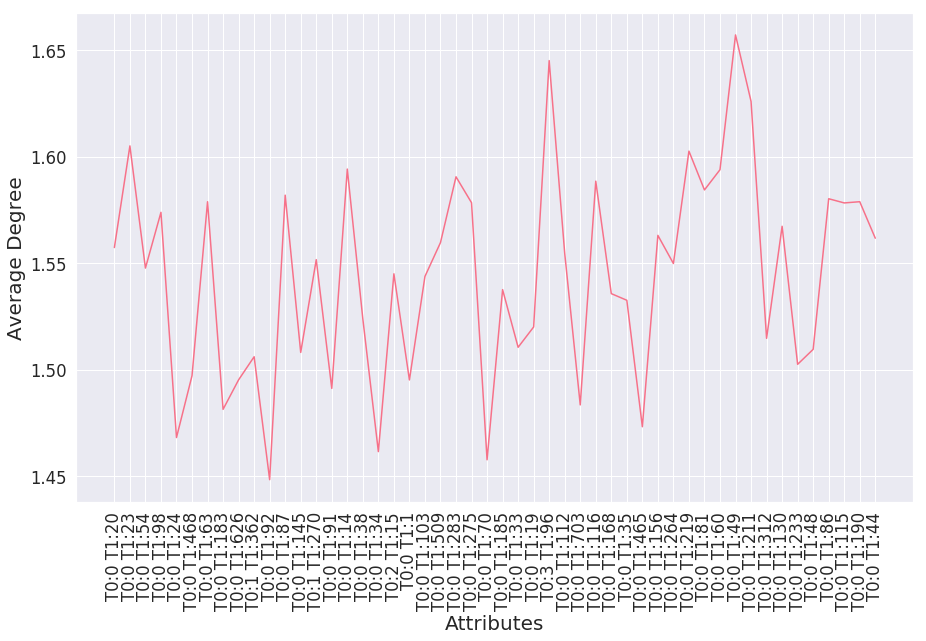

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Prepare the data
ave_degree_data = pd.DataFrame.from_dict({'Attributes':all_attributes, 'Ave_Degree': ave_degree_by_attribute})

# Set the style of seaborn plot
sns.set(style='darkgrid', palette='husl', font_scale=1.5)

# Create matplotlib Figure and Axes object
f, ax = plt.subplots(figsize=(15,9))

# Create the plot
g = sns.lineplot(x='Attributes', y='Ave_Degree', markers=True, data=ave_degree_data)

# Fine Tuning font size
g.set_xticklabels(ave_degree_data['Attributes'], rotation=90)
g.set_xlabel('Attributes', fontsize=20)
g.set_ylabel('Average Degree', fontsize=20)
# g.axes.set_title('Threshold to number of nodes', fontsize=30)

# Display
plt.show(g)

# Save File
fig = g.get_figure()
fig.savefig('./{}.png'.format('ave_degree_distribution'))

Evaluating the performance on the development data, we see that this algorithm fails at predicting certain attributes that are shared among nodes with low degrees. The top 50 attributes make up 25% of all missed attributes, and these nodes have low average degrees below 2. The low degree suggests that these nodes are from sparse areas of the network, therefore, similarity measures relying on neighboring connectivity are not as effective.

## 9. How well does homophily hold? 

Homophiliy refers to the tendency for people to have ties with people who are similar to themselves in socially significant ways. (http://www.analytictech.com/mgt780/topics/homophily.htm)

Check this by creating a subgraph and calculate the similarity scores and plot the distribution out on a histogram. 
For the X-axis, have their attributes 

In [47]:
# Choose a random node, get all neighbors. 
# Use these nodes to create a subgraph of the original graph 
small_graph = grph.subgraph(list(grph.neighbors('6334893')))
                            
# Check that graph is of correct size
print("Number of edges: {}".format(small_graph.number_of_edges())) # There should be 30915267
print("Number of nodes: {}".format(small_graph.number_of_nodes())) # There should be 6626753

Number of edges: 444
Number of nodes: 71


In [48]:
def homophiliy_test_adamic_adar(test_set, grph):
    '''Calculate then adamic/adar similarity of neighbors and return the most similar
    node and the similarity score
    
    :params test_set: target nodes we want to find the most similar neighbor for
    :type test_set: list of str
    :params grph: network containing target nodes
    :type grph: networkx.classes.graph.Graph
    :returns: each nodes most similar neighboring node and their similarity scores
    :rtype: dict of {str : (str, float)}
    '''
    
    # Store results
    sim_results = {}
    
    for i in test_set:
        nearest_neighbors = list(grph.neighbors(i))
        # Make sure that node has neighbors
        if nearest_neighbors:
            # If a node only has only 1 neighbor, inherit that neighbors attributes 
            if len(nearest_neighbors) == 1: 
                sim_results[i] = (nearest_neighbors[0], 0)
            else:
                # Generate node-neighbor pairings 
                node_pairs = [(i, j) for j in nearest_neighbors]
                preds = nx.adamic_adar_index(grph, ebunch=node_pairs)

                # Sort by similarity score
                preds = list(preds)
                preds.sort(key=lambda x: x[2], reverse=True)

                # Take the node with highest sim score
                sim_results[i] = (preds[0][1], preds[0][2])
        else:
            sim_results[i] = 0

    return sim_results

In [49]:
# Calculate the adamic/adar similarity on nodes in the subgraph
sim_results = homophiliy_test_adamic_adar(list(small_graph.nodes), small_graph)                     

In [50]:
# Create pandas dataframe  with node, most similar node, and similarity score
homophily_test = pd.DataFrame({
                        'n': list(sim_results.keys()),
                        'v': [i[0] if i != 0 else i for i in sim_results.values()], 
                        'sim_score': [i[1] if i != 0 else i for i in list(sim_results.values())],
                        })

In [51]:
homophily_test.head()

,n,v,sim_score
0,163000,1950058,8.947507
1,1950058,1992159,9.263532
2,3603369,6579303,3.306734
3,1386558,1950058,1.758797
4,5492245,2019089,0.910239


In [52]:
# Convert 'n' and 'v' columns to int64 to match trainset 
homophily_test[['n','v']] = homophily_test[['n','v']].astype(np.int64)
# Check
type(homophily_test['n'][0])

numpy.int64

In [53]:
# Merge homphily_test dataframe with corresponding attributes to see if they overlap 
homophily_test = homophily_test.merge(train_set, left_on='n', right_on='id', how='left')
homophily_test = homophily_test.merge(train_set, left_on='v', right_on='id', how='left')
# Check results
homophily_test.head()

,n,v,sim_score,id_x,attr_x,id_y,attr_y
0,163000,1950058,8.947507,163000.0,T0:0 T1:1,1950058,T0:0 T1:1 T8:2
1,1950058,1992159,9.263532,1950058.0,T0:0 T1:1 T8:2,1992159,T0:0 T1:1134
2,3603369,6579303,3.306734,3603369.0,T0:0 T1:1,6579303,T0:0 T1:60 T8:0
3,1386558,1950058,1.758797,1386558.0,T0:0 T1:34 T8:1,1950058,T0:0 T1:1 T8:2
4,5492245,2019089,0.910239,5492245.0,T0:0 T1:801 T8:1,2019089,T0:0 T1:92


In [54]:
# Drop uneeded columns and rename 
homophily_test.drop(['id_x', 'id_y'], inplace=True, axis=1)
homophily_test.columns = ['n', 'v', 'sim_score', 'attr_n', 'attr_v']
# Check
homophily_test.head()

,n,v,sim_score,attr_n,attr_v
0,163000,1950058,8.947507,T0:0 T1:1,T0:0 T1:1 T8:2
1,1950058,1992159,9.263532,T0:0 T1:1 T8:2,T0:0 T1:1134
2,3603369,6579303,3.306734,T0:0 T1:1,T0:0 T1:60 T8:0
3,1386558,1950058,1.758797,T0:0 T1:34 T8:1,T0:0 T1:1 T8:2
4,5492245,2019089,0.910239,T0:0 T1:801 T8:1,T0:0 T1:92


In [55]:
# If attributes are equal, assign True, else False
homophily_test = homophily_test.assign(NE=homophily_test['attr_n'] == homophily_test['attr_v'])
# Check
homophily_test.head()

,n,v,sim_score,attr_n,attr_v,NE
0,163000,1950058,8.947507,T0:0 T1:1,T0:0 T1:1 T8:2,False
1,1950058,1992159,9.263532,T0:0 T1:1 T8:2,T0:0 T1:1134,False
2,3603369,6579303,3.306734,T0:0 T1:1,T0:0 T1:60 T8:0,False
3,1386558,1950058,1.758797,T0:0 T1:34 T8:1,T0:0 T1:1 T8:2,False
4,5492245,2019089,0.910239,T0:0 T1:801 T8:1,T0:0 T1:92,False


In [56]:
homophily_test['NE'].value_counts()

False    60
True     11
Name: NE, dtype: int64

In [57]:
false_pred = homophily_test[homophily_test.NE == False].sim_score
true_pred = homophily_test[homophily_test.NE == True].sim_score

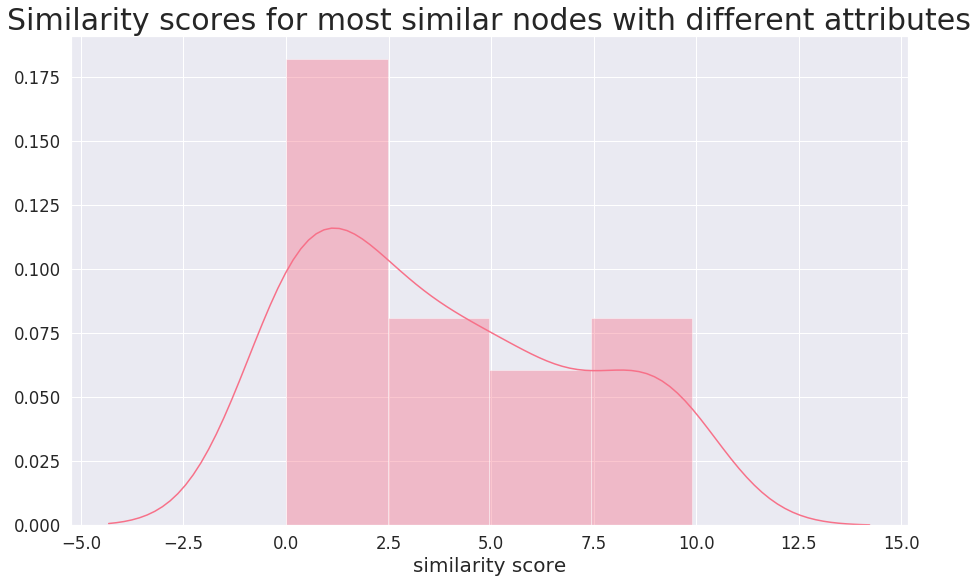

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set the style of seaborn plot
sns.set(style='darkgrid', palette='husl', font_scale=1.5)

# Create matplotlib Figure and Axes object
f, ax = plt.subplots(figsize=(15,9))

# Create the plot
g = sns.distplot(false_pred.tolist())

# Fine Tuning font size
g.set_xlabel('similarity score', fontsize=20)
# g.set_ylabel('Number of Nodes', fontsize=20)
g.axes.set_title('Similarity scores for most similar nodes with different attributes', fontsize=30)

# Display
plt.show(g)

# Save File
fig = g.get_figure()
fig.savefig('./{}.png'.format('ave_degree_distribution_diff_attributes'))

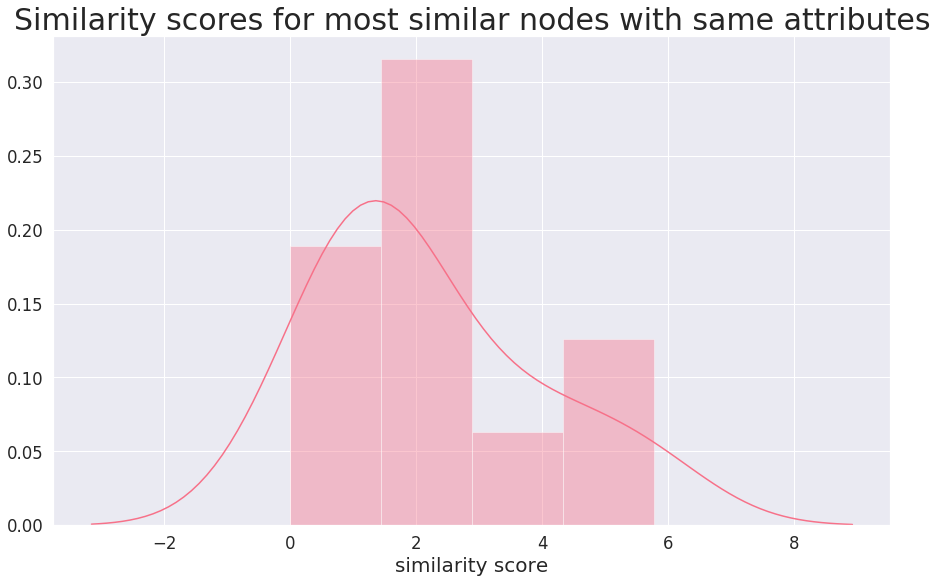

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set the style of seaborn plot
sns.set(style='darkgrid', palette='husl', font_scale=1.5)

# Create matplotlib Figure and Axes object
f, ax = plt.subplots(figsize=(15,9))

# Create the plot
g = sns.distplot(true_pred.tolist())

# Fine Tuning font size
g.set_xlabel('similarity score', fontsize=20)
# g.set_ylabel('Number of Nodes', fontsize=20)
g.axes.set_title('Similarity scores for most similar nodes with same attributes', fontsize=30)

# Display
plt.show(g)

# Save File
fig = g.get_figure()
fig.savefig('./{}.png'.format('ave_degree_distribution_same_attributes'))

In [71]:
# True AttributePredictions 
homophily_test[homophily_test.NE == True].sort_values('sim_score', ascending=False).head(10)

,n,v,sim_score,attr_n,attr_v,NE
60,3334731,163000,5.769897,T0:0 T1:1,T0:0 T1:1,True
42,1747109,3848051,4.571465,T0:0 T1:1,T0:0 T1:1,True
40,6012432,1648311,3.570321,T0:0 T1:1,T0:0 T1:1,True
39,1981318,163000,2.658527,T0:0 T1:1,T0:0 T1:1,True
23,3820833,3334731,1.766373,T0:0 T1:1,T0:0 T1:1,True
10,1644653,4425527,1.442695,T0:0 T1:1041,T0:0 T1:1041,True
45,1101787,1644653,1.442695,T0:0 T1:1041,T0:0 T1:1041,True
58,4425527,1644653,1.442695,T0:0 T1:1041,T0:0 T1:1041,True
69,2391232,5261893,0.991117,T0:0 T1:1,T0:0 T1:1,True
12,3717094,1648311,0.417032,T0:0 T1:1,T0:0 T1:1,True


In [72]:
# False Attribute Predictions 
homophily_test[homophily_test.NE == False].sort_values('sim_score', ascending=False).head(10)

,n,v,sim_score,attr_n,attr_v,NE
49,6579303,1992159,9.906461,T0:0 T1:60 T8:0,T0:0 T1:1134,False
8,1992159,6579303,9.906461,T0:0 T1:1134,T0:0 T1:60 T8:0,False
34,3848051,1992159,9.272437,T0:0 T1:1,T0:0 T1:1134,False
1,1950058,1992159,9.263532,T0:0 T1:1 T8:2,T0:0 T1:1134,False
50,616018,6579303,9.118332,T0:0 T1:1 T8:2,T0:0 T1:60 T8:0,False
52,2551705,1950058,9.085753,T0:0 T1:1 T8:1,T0:0 T1:1 T8:2,False
0,163000,1950058,8.947507,T0:0 T1:1,T0:0 T1:1 T8:2,False
43,4923461,1950058,8.922026,T0:0 T1:1,T0:0 T1:1 T8:2,False
32,5000153,1950058,8.702294,T0:0 T1:1,T0:0 T1:1 T8:2,False
36,6004908,2551705,8.682391,T0:0 T1:1,T0:0 T1:1 T8:1,False


For the particular dataset, homophily does not appear to hold well. Again, homophily in a social context explains that people who share similarities in socially significant ways are more likely to be linked. A subgraph of the original graph was created using the neighboring nodes of a randomly selected node. For each node in the subgraph, we calculated the similarity scores with its neighbors (if any), and returned the highest similarity score which was plotted on a histogram. It appears that most of the similarity scores were on the lower end (right-skewed) except a few with high similarity scores, and most nodes did not share the same attributes as only 11 of 71 nodes did. Of nodes with matching attributes, it seems the majority had low similarity scores as well (right-skewed). 

# Future Approaches 

For the next steps, I would like to revise my current approach for attribute predictions and see how the algorithm can be improved by taking into account attribute trends. From observing the data, I realized that out of the three classes of attributes (T0, T1, and T8), T0 and T1 were far more prevalent than T8. Perhaps, in real life social network, T0 and T1 are attributes much more common among users, whereas T8 is rarer and much more specific. For example, in LinkedIn, T0 could be a user’s educational background which, whereas T8 could be a professional certification a user has obtained. On a business professional network, ones educational background is a common attribute included in many profiles, but much fewer individuals may have certifications listed, such as being certified doctor, lifeguard, lawyer, etc. 
 
For more common classes of attributes (T0, T1), I could develop an algorithm that counts and assigns the most common attribute shared among all nearest neighbors. For example, in a given scenario, if T0:1 was more common than T0:2 out of all nearest neighbors, then inherit T0:1. 

For rarer classes of attributes (T8), I would use my current method of inheriting the attribute of the most similar neighbor as calculated by the Adamic/Adar algorithm. In cases where multiple nodes have the same similarity score and also have different variations of the rare attribute, I could either select the winning attribute randomly or by frequency (e.g., T8:213 might be more common than T8:121, so inherit T8:213).

Treat attributes as itemsets which can be used to build association rules (e.g, If T0:12 and T1:334 are present, then T8:123 is also likely to be present). 

Additionally, I would like to explore other network based algorithms that may improve the performance (BFS, DFS, eigenvector centrality, etc). 